In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.nn.functional import normalize
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from multiprocessing import Pool, cpu_count

from tqdm import tqdm
import os

In [2]:
to_load = [
    "esm3",
    "Isolated",
    "6xf5_noisy",
    "no_relax",
    "minim_gromacs_mutated",
    "first_relax",
    "md_frame",
    "noisy_mutated",
]

In [3]:
def load_data(path_to_data, to_load):
    # Load data
    # path_to_data = '../data-bloom/'
    # path_to_data = '../data-bloom/'

    ## Regroup all embeddings
    # find all files beginning with embeddings
    # files = [f for f in os.listdir(path_to_data) if f.startswith('embeddings') if any([tl in f for tl in to_load])]
    # files.sort()
    files = []
    for tl in to_load:
        files += [f for f in os.listdir(path_to_data) if f.startswith('embeddings') if tl in f]
    embeddings = []
    for file in files:
        embeddings.append(torch.load(path_to_data + file).to(float))
    embeddings_names = ["_".join(f.split('_')[2:]) for f in files]

    # Load kd
    kd_ace = torch.load(path_to_data + 'logKd_ACE2.pt')
    return embeddings, embeddings_names, kd_ace

In [4]:
kd_cov = torch.load('../data/logKd_COV555.pt')
kd_s309 = torch.load('../data/logKd_S309.pt')
kd_regn = torch.load('../data/logKd_REGN10987.pt')
kd_cb6 = torch.load('../data/logKd_CB6.pt')

/tmp/ipykernel_2327508/1361700120.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kd_cov = torch.load('../data/logKd_COV555.pt')
/tmp/ipykernel_2327508/1361700120.py:2: 

In [4]:
embeddings, embeddings_names, kd_ace = load_data('../data-bloom/', to_load)

/tmp/ipykernel_3540150/2864966188.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(path_to_data + file).to(float))


/tmp/ipykernel_3540150/2864966188.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kd_ace = torch.load(path_to_data + 'logKd_ACE2.pt')


In [5]:
embeddings_names

['esm3.pt',
 'Isolated_WT_down_state_6xf5.pt',
 '6xf5_noisy_same_structure.pt',
 'no_relax_mutated.pt',
 'minim_gromacs_mutated_6xf5.pt',
 'first_relax.pt.pt',
 'md_frame.pt.pt',
 'noisy_mutated_6xf5_01.pt']

In [6]:
embeddings_renames = [
    'Sequence Only',
    'Wildtype',
    "Noisy Wildtype",
    'EvoEF2 BuildMutant',
    'Gromacs Minimization',
    'Rosetta Relax',
    'Noisy 0.1A',
    'MD Frame'
]

In [7]:
embeddings_desai, embeddings_names_desai, kd_desai = load_data('../data/', to_load)

/tmp/ipykernel_3540150/2864966188.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(path_to_data + file).to(float))


In [ ]:
embeddings_names_desai

['esm3_only_desai_old.pt',
 'Isolated_WT_down_state_6xf5.pt',
 '6xf5_noisy.pt',
 'no_relax_mutated_WT_6xf5.pt',
 'minim_gromacs_mutated_6xf5.pt',
 'first_relax_rbd_mutated_WT_6xf5.pt',
 'md_frame_WT_6xf5.pt',
 'noisy_mutated_6xf5_01.pt']

In [10]:
# For sequence-only + some structure
to_load2 = [
    "esm1",
    "esm2",
    "esm3",
    "Delta_7w9i",
    "WT_7kmg",
    "Isolated"
]

In [11]:
embeddings2, embeddings_names2, kd_ace2 = load_data('../data-bloom/', to_load2)

/tmp/ipykernel_2327508/2864966188.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(path_to_data + file).to(float))


/tmp/ipykernel_2327508/2864966188.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kd_ace = torch.load(path_to_data + 'logKd_ACE2.pt')


In [12]:
embeddings_desai2, embeddings_desai_names2, kd_desai2 = load_data('../data/', to_load2)

/tmp/ipykernel_2327508/2864966188.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(path_to_data + file).to(float))


/tmp/ipykernel_2327508/2864966188.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kd_ace = torch.load(path_to_data + 'logKd_ACE2.pt')


In [13]:
embeddings_names2

['esm1v_650m.pt',
 'esm2_650m.pt',
 'esm2_15b.pt',
 'esm3.pt',
 'ACE2_Delta_7w9i.pt',
 'Cov555_WT_7kmg.pt',
 'Isolated_WT_down_state_6xf5.pt']

In [14]:
embeddings_renames2 = [
    "ESM1 650M Sequence",
    "ESM2 650M Sequence",
    "ESM2 15B Sequence",
    "ESM3 3B Sequence",
    "ESM3 7W9I Structure",
    "ESM3 7KMG Structure",
    "ESM3 6XF5 Structure"
]

In [15]:
embeddings_desai_names2

['esm1v_650m.pt',
 'esm2_650m.pt',
 'esm2_15b.pt',
 'esm3_only_desai_old.pt',
 'ACE2_Delta_7w9i.pt',
 'Cov555_WT_7kmg.pt',
 'Isolated_WT_down_state_6xf5.pt']

In [ ]:
def normalize_kd(kd):
    return (kd - kd.mean()) / kd.std()
def normalize_embeddings(embeddings):
    return (embeddings - embeddings.mean(dim=1)) / embeddings.std(dim=1)

embeddings_normalize = [normalize_embeddings(embedding) for embedding in embeddings]
embeddings_desai_normalize = [normalize_embeddings(embedding) for embedding in embeddings_desai]

# embeddings_normalize2 = [normalize_embeddings(embedding) for embedding in embeddings2]
# embeddings_desai_normalize2 = [normalize_embeddings(embedding) for embedding in embeddings_desai2]

In [ ]:
def evaluate(seed, embeddings_X, embedding_name, kd_Y, model_class, model_params, train_size, test_size, scaler=None):
    # Set seed for reproducibility
    index = np.arange(len(embeddings_X))
    np.random.seed(seed)

    index_train, index_test = train_test_split(index, test_size=test_size, train_size=train_size, random_state=seed)
    train_y = kd_Y[index_train]
    test_y = kd_Y[index_test]
    # Split the data into training and test sets
    train_X = embeddings_X[index_train]
    test_X = embeddings_X[index_test]

    # Set different random seeds for each repetition
    # seeds = np.arange(42, 42 + num_repeats)

    # Perform the benchmark
    model = model_class(**model_params)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)

    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
        test_y = scaler.inverse_transform(test_y.reshape(-1, 1)).reshape(-1)

    r2 = r2_score(test_y, predictions)
    spearman, _ = spearmanr(predictions, test_y)
    mse = mean_squared_error(test_y, predictions)
    return {"embedding": embedding_name, "r2": r2, "spearman": spearman, "mse": mse, "seed": seed}
    

def evaluate_embeddings_all_metrics_regression_multiprocessing(embeddings_list, kd_Y, name_dataset, model_class, embeddings_name, kd_name, train_size=500, test_size=500, num_repeats=1, model_params={}, verbose=False, prefix="", renormalize=False, title=""):
    index = np.arange(len(embeddings_list[0]))
    # Select training and test data

    if renormalize:
        kd_scalers = [StandardScaler() for _ in range(len(embeddings_list))]
        kd_Y = [kd_scaler.fit_transform(kd.reshape(-1, 1)).reshape(-1) for kd_scaler, kd in zip(kd_scalers, kd_Y)]

    if num_repeats>1:
        seeds = np.arange(45, 45 + num_repeats)
    else:
        seeds = [np.random.randint(0, 1000)]

    results = []
    with Pool(cpu_count()//4) as p:
        for i in range(len(embeddings_list)):
            results.append(p.starmap(evaluate, tqdm([(seed, embeddings_X, embeddings_name[ind], kd_Y[i], model_class, model_params, train_size, test_size, kd_scalers[i] if renormalize else None) for ind, embeddings_X in enumerate(embeddings_list[i]) for seed in seeds], total=len(embeddings_list[i])*len(seeds))))

    metrics = ['r2', 'spearman', 'mse']
    colours = ['b', 'g', 'r']

    # Create a figure and an array of subplots with one row per metric

    ## For figure 1 and 2 
    # fig, axs = plt.subplots(1, len(embeddings_list), figsize=(4*len(embeddings_list), 4))
    fig, axs = plt.subplots(1, len(embeddings_list), figsize=(12, 4.5))
    # fig.tight_layout(pad=5.0)
    fig.tight_layout(pad=5.0)

    results =  [pd.DataFrame(result) for result in results]

    labelsize = 17
    
    # Plot each metric in a separate subplot
    for i in range(len(results)):
        sns.boxplot(x="spearman", y="embedding", hue='embedding', data=results[i], ax=axs[i], orient='h', palette='Set2', vert=False)
        # ax.set_xlabel('Spearman Correlation Coefficient')
        # axs[i].set_title(f'Spearman Metric - {name_dataset[i]}', fontsize=labelsize)
        axs[i].set_title(f'{name_dataset[i]}', fontsize=labelsize)
        axs[i].grid(True, which="both", linestyle="--", linewidth=0.5)
        axs[i].set_ylabel('')
        axs[i].set_xlabel('Spearman', fontsize=labelsize)
        # change size font of y-ticks
        axs[i].tick_params(axis='y', labelsize=labelsize)
        axs[i].tick_params(axis='x', labelsize=labelsize)
        # axs[i].tick_params(axis='x', labelsize=labelsize)

        # Remove y-tick labels for all but the first subplot
        if axs[i] != axs[0]:
            axs[i].set_yticklabels([])

    # Add a legend at the bottom for all metrics
    # legend_elements = [mpatches.Patch(color=colour, label=metric.capitalize()) for colour, metric in zip(colours, metrics)]
    # fig.legend(handles=legend_elements)
    plt.suptitle(title, fontsize=15)
    fig.savefig(f'{prefix}{kd_name}_{model_class.__name__}_train_size_{train_size}_regression.png', bbox_inches='tight')
    plt.show()

 39%|███████████████████████▎                                    | 93/240 [00:00<00:00, 278.00it/s]

100%|████████████████████████████████████████████████████████████| 240/240 [00:17<00:00, 14.05it/s]


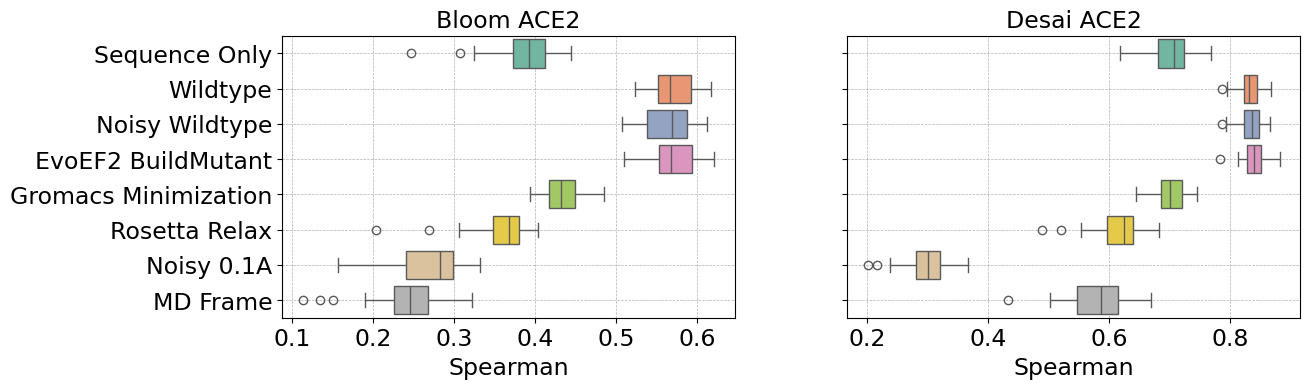

In [ ]:
# title = "Performance of different structure pipelines on ACE2 binding affinity prediction"
title = ""
evaluate_embeddings_all_metrics_regression_multiprocessing([embeddings_normalize, embeddings_desai_normalize], [kd_ace, kd_desai], ["Bloom ACE2", "Desai ACE2"], SVR, embeddings_renames, "ACE2", num_repeats=5, train_size=100, test_size=0.5, model_params={}, prefix="all_renom1", renormalize=True, title=title)

 30%|█████████████████▋                                          | 62/210 [00:00<00:00, 307.31it/s]

100%|████████████████████████████████████████████████████████████| 210/210 [00:24<00:00,  8.64it/s]


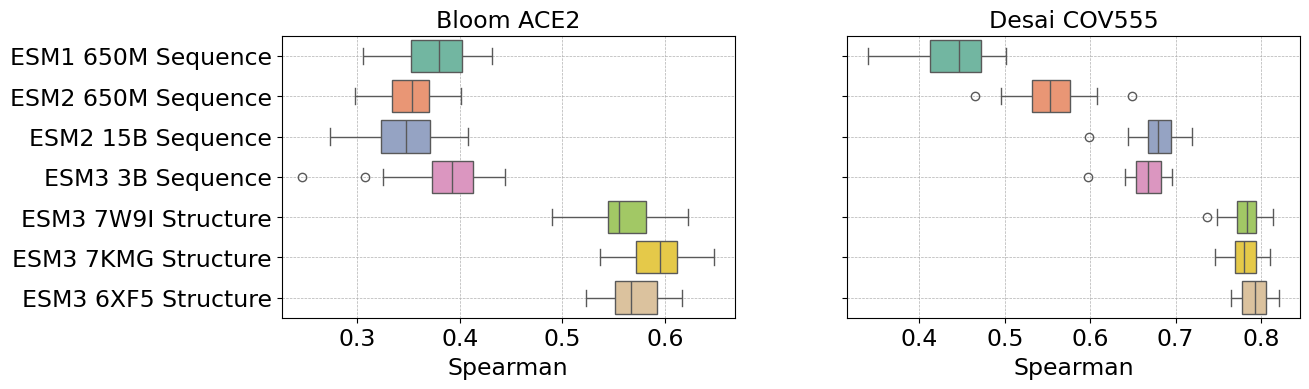

In [24]:
title = ""

evaluate_embeddings_all_metrics_regression_multiprocessing([embeddings_normalize2, embeddings_desai_normalize2], [kd_ace2, kd_cov], ["Bloom ACE2", "Desai COV555"], SVR, embeddings_renames2, "ACE2", num_repeats=30, train_size=100, test_size=0.5, model_params={}, prefix="seq_struct_small", renormalize=True, title=title)

 24%|██████████████▎                                             | 38/160 [00:00<00:00, 302.21it/s]

100%|████████████████████████████████████████████████████████████| 160/160 [00:11<00:00, 14.54it/s]


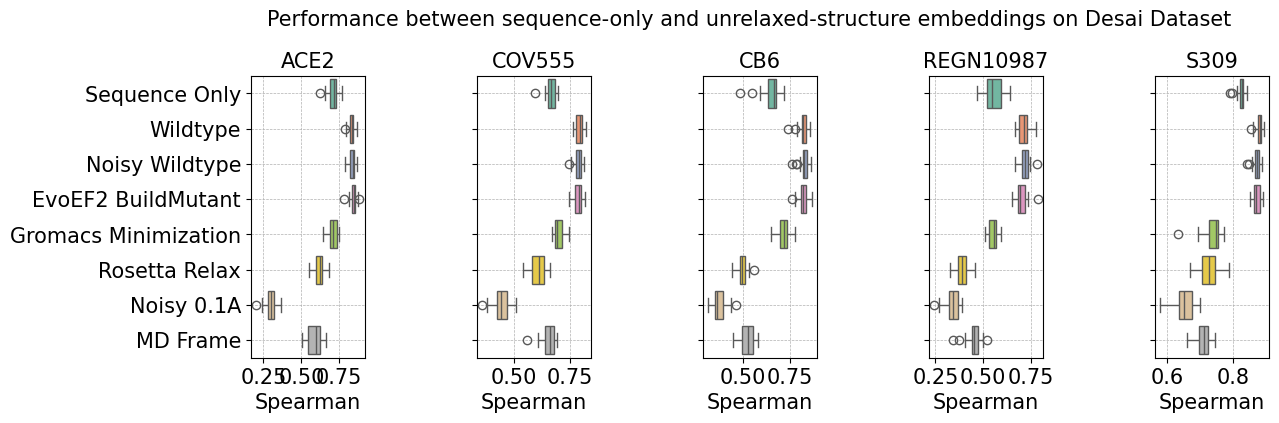

In [20]:
title = "Performance between sequence-only and unrelaxed-structure embeddings on Desai Dataset"

evaluate_embeddings_all_metrics_regression_multiprocessing([embeddings_desai_normalize,embeddings_desai_normalize,embeddings_desai_normalize,embeddings_desai_normalize,embeddings_desai_normalize], [kd_desai, kd_cov, kd_cb6, kd_regn, kd_s309], ["ACE2", "COV555", "CB6", "REGN10987", "S309"], SVR, embeddings_renames, "ACE2", num_repeats=20, train_size=100, test_size=0.5, model_params={}, prefix="all_desai_", renormalize=True, title=title)

 24%|██████████████▌                                             | 34/140 [00:00<00:00, 196.36it/s]

100%|████████████████████████████████████████████████████████████| 140/140 [00:13<00:00, 10.44it/s]


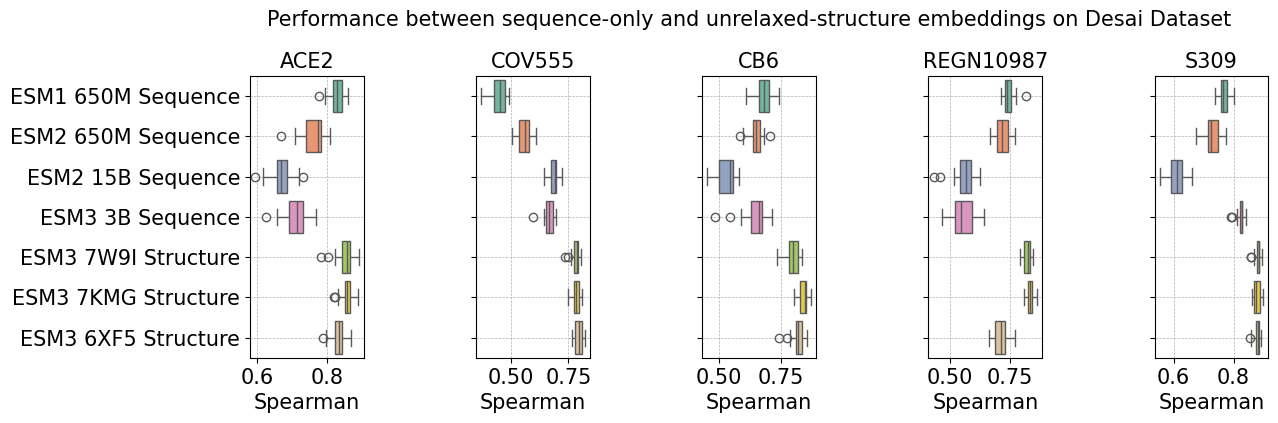

In [21]:
title = "Performance between sequence-only and unrelaxed-structure embeddings on Desai Dataset"

evaluate_embeddings_all_metrics_regression_multiprocessing([embeddings_desai_normalize2,embeddings_desai_normalize2, embeddings_desai_normalize2, embeddings_desai_normalize2,embeddings_desai_normalize2], [kd_desai, kd_cov, kd_cb6, kd_regn, kd_s309], ["ACE2", "COV555", "CB6", "REGN10987", "S309"], SVR, embeddings_renames2, "ACE2", num_repeats=20, train_size=100, test_size=0.5, model_params={}, prefix="all_desai_", renormalize=True, title=title)